Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

MUST DO THIS FIRST
-------------------
___

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys, glob
import tarfile
import IPython.display # for display, Image # ok to skip
from scipy import ndimage                  # ok to skip
import sklearn.linear_model # for LogisticRegression # ok to skip
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import random

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


OPTIONAL (IF ALREADY DONE) FILE DOWNLOAD AND STRUCTURE STEPS
------------------------------------------------
This notebook uses the notMNIST dataset to be used with python experiments. This dataset is designed to look like the classic MNIST dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.
___

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

('Found and verified', 'notMNIST_large.tar.gz')
('Found and verified', 'notMNIST_small.tar.gz')


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10

def maybe_extract(filename):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if not os.path.exists(root): 
      tar = tarfile.open(filename)
      print('Extracting data for %s. This may take a while. Please wait.' % root)
      sys.stdout.flush()
      tar.extractall()
      tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root)) 
        if (d != '.DS_Store') 
        and os.path.isdir(os.path.join(root,d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    image_index = 0
    print folder
    for image in os.listdir(folder):
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file).astype(float) - 
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data
        image_index += 1
      except IOError as e:
        print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    num_images = image_index
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % 
                        (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def load(data_folders, min_num_images_per_class):
  dataset_names = []
  for folder in data_folders:
    dataset = load_letter(folder, min_num_images_per_class)
    set_filename = folder + '.pickle'
    try:
        with open(set_filename, 'wb') as f:
            pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
        dataset_names.append(set_filename)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
    print(dataset_names)
  return dataset_names

def maybe_load_or_read(data_folders, min_num_images_per_class):
  for df in data_folders:
    pickle_files = glob.glob(os.path.join(os.path.dirname(df), '*.pickle'))
    pickle_files = sorted(pickle_files)
  if not pickle_files:
    print('Calling load')
    return load(data_folders, min_num_images_per_class)
  if len(pickle_files) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(pickle_files)))
  print(pickle_files)
  return pickle_files

train_datasets = maybe_load_or_read(train_folders, 45000)
test_datasets = maybe_load_or_read(test_folders, 1800)

['notMNIST_large/A.pickle', 'notMNIST_large/B.pickle', 'notMNIST_large/C.pickle', 'notMNIST_large/D.pickle', 'notMNIST_large/E.pickle', 'notMNIST_large/F.pickle', 'notMNIST_large/G.pickle', 'notMNIST_large/H.pickle', 'notMNIST_large/I.pickle', 'notMNIST_large/J.pickle']
['notMNIST_small/A.pickle', 'notMNIST_small/B.pickle', 'notMNIST_small/C.pickle', 'notMNIST_small/D.pickle', 'notMNIST_small/E.pickle', 'notMNIST_small/F.pickle', 'notMNIST_small/G.pickle', 'notMNIST_small/H.pickle', 'notMNIST_small/I.pickle', 'notMNIST_small/J.pickle']


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [5]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
          print('Unable to process data from', pickle_file, ':', e)
          raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
__, __, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

('Training:', (200000, 28, 28), (200000,))
('Validation:', (10000, 28, 28), (10000,))
('Testing:', (10000, 28, 28), (10000,))


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [6]:
np.random.seed(133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

Finally, let's save the data for later reuse:

In [7]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 690800441)


(OPTIONAL) COOL DATA CHECKING SNIPPETS
----------------------------------------
___

In [8]:
## Display a sample of the images

import glob, random

image_files = glob.glob(os.path.join(os.path.dirname(train_folders[0]), '*','*.png'))
example_images = random.sample(image_files, 5)
print(example_images)

def display_samples(filenames):
    for f in filenames:
        print(f)
        image = IPython.display.Image(filename=f) #Image from IPython.display
        IPython.display.display(image)            #display from IPython.display
    
display_samples(example_images)

['notMNIST_large/A/QW5hcmNrV2FycC50dGY=.png', 'notMNIST_large/A/T2ZmbGluZS1Sb3VnaC5vdGY=.png', 'notMNIST_large/H/SW1mb3JuYXRpb24ub3Rm.png', 'notMNIST_large/B/RnJlaWdodERpc3BCb29rU0MudHRm.png', 'notMNIST_large/C/RmxpbnRzdG9uZSBFeHRlbmRlZCBJdGFsaWMudHRm.png']
notMNIST_large/A/QW5hcmNrV2FycC50dGY=.png


notMNIST_large/A/T2ZmbGluZS1Sb3VnaC5vdGY=.png


notMNIST_large/H/SW1mb3JuYXRpb24ub3Rm.png


notMNIST_large/B/RnJlaWdodERpc3BCb29rU0MudHRm.png


notMNIST_large/C/RmxpbnRzdG9uZSBFeHRlbmRlZCBJdGFsaWMudHRm.png


notMNIST_large/I.pickle


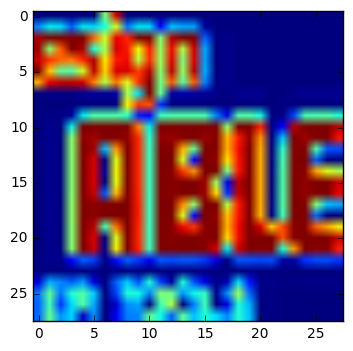

In [9]:
# Verify that the data still looks good after creating the pickle file for each letter
#   use matplotlib.pyplot

sample_dataset_pickle_filename = random.choice(train_datasets)
print(sample_dataset_pickle_filename)
with open(sample_dataset_pickle_filename, 'rb') as d:
    letter_set = pickle.load(d)
%matplotlib inline
random_index = random.randint(0, len(letter_set))
plt.imshow(letter_set[random_index])

In [10]:
# Verify that the data is balanced across classes (letters)

for picklefile in train_datasets:
    with open(picklefile) as p:
        letter_set = pickle.load(p)
    print '%s: %s' % (picklefile, letter_set.shape)
print 'Done'

notMNIST_large/A.pickle: (52912, 28, 28)
notMNIST_large/B.pickle: (52912, 28, 28)
notMNIST_large/C.pickle: (52912, 28, 28)
notMNIST_large/D.pickle: (52912, 28, 28)
notMNIST_large/E.pickle: (52912, 28, 28)
notMNIST_large/F.pickle: (52912, 28, 28)
notMNIST_large/G.pickle: (52912, 28, 28)
notMNIST_large/H.pickle: (52912, 28, 28)
notMNIST_large/I.pickle: (52912, 28, 28)
notMNIST_large/J.pickle: (52911, 28, 28)
Done


(200000, 28, 28) (200000,)
(10000, 28, 28) (10000,)


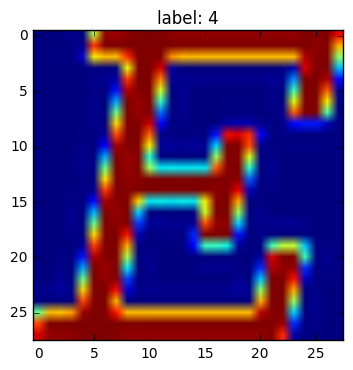

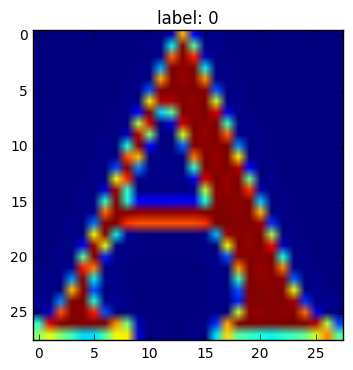

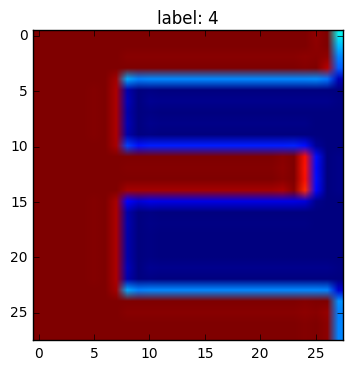

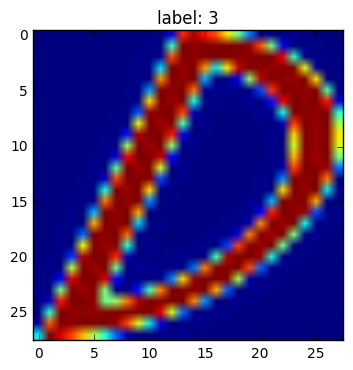

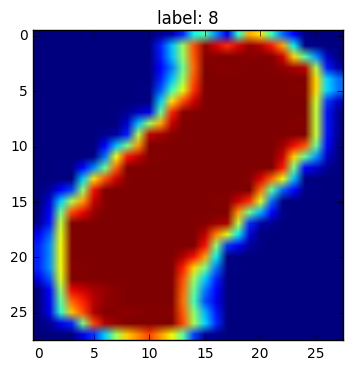

In [11]:
# Make sure data is still good after randomization

num_plots = 5

print train_dataset.shape, train_labels.shape
print test_dataset.shape, test_labels.shape
indices = random.sample(xrange(len(train_dataset)), num_plots)
%matplotlib inline
for i in indices:
    #print 'label: %s' % train_labels[i]
    #plt.subplot(num_plots, 1, i)
    plt.figure(i)
    plt.title('label: %s' % train_labels[i])
    plt.imshow(train_dataset[i])

In [12]:
# 3 Methods for looking to see if there are duplicates or overlaps between the samples in my test, validation and training
#  sets.

import time

def fast_overlaps_num_set_and_hash(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    hash1 = set([hash(image1.data) for image1 in images1])
    hash2 = set([hash(image2.data) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return len(all_overlaps)

def find_dups_and_overlaps(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    dup_table={}
    duplicates1 = []
    for idx,img in enumerate(images1):
        h = hash(img.data)
        if h in dup_table and (images1[dup_table[h]].data == img.data):
            duplicates1.append((idx, dup_table[h]))
            #print 'Duplicate image: %d matches %d' % (idx, dup_table[h])
        dup_table[h] = idx
    overlaps = []
    for idx,img in enumerate(images2):
        h = hash(img.data)
        if h in dup_table and (images1[dup_table[h]].data == img.data):
            overlaps.append((dup_table[h], idx))
            #print 'Test image %d is in the training set' % idx
    return duplicates1, overlaps

def num_overlaps_with_diff_labels(overlap_indices, labels1, labels2):
    count = 0
    for olap in overlap_indices:
        if labels1[olap[0]] != labels2[olap[1]]:
            count += 1
    return count

def faster_overlaps_hashlib_and_numpy():
    import hashlib

    train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
    valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
    test_hashes  = [hashlib.sha1(x).digest() for x in test_dataset]

    valid_in_train = np.in1d(valid_hashes, train_hashes)
    test_in_train  = np.in1d(test_hashes,  train_hashes)
    test_in_valid  = np.in1d(test_hashes,  valid_hashes)

    valid_keep = ~valid_in_train
    test_keep  = ~(test_in_train | test_in_valid)

    valid_dataset_clean = valid_dataset[valid_keep]
    valid_labels_clean  = valid_labels [valid_keep]

    test_dataset_clean = test_dataset[test_keep]
    test_labels_clean  = test_labels [test_keep]

    print("valid -> train overlap: %d samples" % valid_in_train.sum())
    print("test  -> train overlap: %d samples" % test_in_train.sum())
    print("test  -> valid overlap: %d samples" % test_in_valid.sum())
    
print '\nMethod 1: hash and check equality'
t1 = time.time()
train_dups, train_valid_overlaps = find_dups_and_overlaps(train_dataset, valid_dataset)
test_dups, test_train_overlaps = find_dups_and_overlaps(test_dataset, train_dataset)
valid_dups, valid_test_overlaps = find_dups_and_overlaps(valid_dataset, test_dataset)
print 'train dups: %s, test_dups: %s, valid_dups: %s' % (len(train_dups), len(test_dups), len(valid_dups))
print 'train/valid overlaps: %s, of which %s have different labels' % \
    (len(train_valid_overlaps), num_overlaps_with_diff_labels(train_valid_overlaps, train_labels, valid_labels))
print 'test/train overlaps: %s, of which %s have different labels' % \
    (len(test_train_overlaps), num_overlaps_with_diff_labels(test_train_overlaps, test_labels, train_labels))
print 'valid/test overlaps: %s, of which %s have different labels' % \
    (len(valid_test_overlaps), num_overlaps_with_diff_labels(valid_test_overlaps, valid_labels, test_labels))
t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))

print '\nMethod 2: hash and set'
t1 = time.time()
print 'fast train/validation overlaps: %s ' % fast_overlaps_num_set_and_hash(train_dataset, valid_dataset)
print 'fast train/test overlaps: %s' % fast_overlaps_num_set_and_hash(train_dataset, test_dataset)
print 'fast test/validation overlaps: %s' % fast_overlaps_num_set_and_hash(test_dataset, valid_dataset)
t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))

print '\nMethod 3: hashlib and numpy'
t1 = time.time()
faster_overlaps_hashlib_and_numpy()
t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))



Method 1: hash and check equality
train dups: 12456, test_dups: 189, valid_dups: 151
train/valid overlaps: 1064, of which 0 have different labels
test/train overlaps: 3389, of which 39 have different labels
valid/test overlaps: 199, of which 0 have different labels
Time: 2.27s

Method 2: hash and set
fast train/validation overlaps: 930 
fast train/test overlaps: 1191
fast test/validation overlaps: 69
Time: 2.20s

Method 3: hashlib and numpy
valid -> train overlap: 1064 samples
test  -> train overlap: 1347 samples
test  -> valid overlap: 199 samples
Time: 1.55s


START HERE WHEN RETURNING (AFTER DOING THE IMPORTS SECTION AT TOP)
---------------------------------------------------------------------
___

First reload the data we generated in _notmist.ipynb_.

In [13]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (200000, 28, 28), (200000,))
('Validation set', (10000, 28, 28), (10000,))
('Test set', (10000, 28, 28), (10000,))


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [14]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (200000, 784), (200000, 10))
('Validation set', (10000, 784), (10000, 10))
('Test set', (10000, 784), (10000, 10))


In [15]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compue the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Answer
------
I added in the regularization code below.  It is just a regularization term that is added to loss.  I used just one beta and tuned it (my first attempt was 5e-4, which resulted in 88.5% test accuracy -- beta of 5e-3 got to 91.2%).  I could consider using a different beta for the different weight and bias variables.

In [16]:
batch_size = 128
num_hidden_nodes = 1024
beta = 5e-3

graph = tf.Graph()
with graph.as_default():
    
    with tf.name_scope('inputs'):
        # Input data. For the training data, we use a placeholder that will be fed
        # at run time with a randomly selected (stochastic) training minibatches.
        tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)
    
    with tf.name_scope('hidden'):
        weights1 = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_hidden_nodes]),  # 1st num: inputsize, 2nd num: outputsize       
            name='weights')
        biases1 = tf.Variable(
            tf.zeros([num_hidden_nodes]), name='biases')
        hidden_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
        hidden_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        hidden_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        
    with tf.name_scope('softmax_linear'):
        weights2 = tf.Variable(
            tf.truncated_normal([num_hidden_nodes, num_labels]),  # 1st num: inputsize, 2nd num: outputsize       
            name='weights')
        biases2 = tf.Variable(
            tf.zeros([num_labels]), name='biases')
        logits_train = tf.matmul(hidden_train, weights2) + biases2
        logits_valid = tf.matmul(hidden_valid, weights2) + biases2
        logits_test = tf.matmul(hidden_test, weights2) + biases2

    # add a term to the loss called regularizatio
    regularizations = beta * (tf.nn.l2_loss(weights1) + 
                              tf.nn.l2_loss(weights2) +
                              tf.nn.l2_loss(biases1) + 
                              tf.nn.l2_loss(biases2))

    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits_train, tf_train_labels)) + \
        regularizations
  
  # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits_train)
    valid_prediction = tf.nn.softmax(logits_valid)
    test_prediction = tf.nn.softmax(logits_test)

In [17]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 1916.020020
Minibatch accuracy: 14.8%
Validation accuracy: 23.6%
Minibatch loss at step 500: 127.193420
Minibatch accuracy: 82.8%
Validation accuracy: 82.7%
Minibatch loss at step 1000: 10.918501
Minibatch accuracy: 84.4%
Validation accuracy: 86.2%
Minibatch loss at step 1500: 1.424592
Minibatch accuracy: 85.2%
Validation accuracy: 86.1%
Minibatch loss at step 2000: 0.797713
Minibatch accuracy: 82.8%
Validation accuracy: 85.8%
Minibatch loss at step 2500: 0.509750
Minibatch accuracy: 87.5%
Validation accuracy: 86.3%
Minibatch loss at step 3000: 0.687732
Minibatch accuracy: 84.4%
Validation accuracy: 84.6%
Test accuracy: 90.5%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Answer
------
In the code below, instead of randomly choosing an offset for selecting the random batch, I cycle through just a limited number of offsets (re-using the same small set of batches).  The batch size is still 128 and the number of steps is still 3001, but I'm using fewer unique batches.

At 50 unique batches, the minibatch accuracy ended at 94.5% and test accuracy was 89.7%

at 10 unique batches, the minibatch accuracy ended at 100% and test accuracy was 87.2%

at 5  unique batches, the minibatch accuracy ended at 100% and test accuracy was 86.3%

In [18]:
batch_size = 128
num_steps = 3001
num_unique_batches = 5
num_hidden_nodes = 1024
beta = 5e-3

graph = tf.Graph()
with graph.as_default():
    
    with tf.name_scope('inputs'):
        # Input data. For the training data, we use a placeholder that will be fed
        # at run time with a randomly selected (stochastic) training minibatches.
        tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)
    
    with tf.name_scope('hidden'):
        weights1 = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_hidden_nodes]),  # 1st num: inputsize, 2nd num: outputsize       
            name='weights')
        biases1 = tf.Variable(
            tf.zeros([num_hidden_nodes]), name='biases')
        hidden_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
        hidden_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        hidden_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        
    with tf.name_scope('softmax_linear'):
        weights2 = tf.Variable(
            tf.truncated_normal([num_hidden_nodes, num_labels]),  # 1st num: inputsize, 2nd num: outputsize       
            name='weights')
        biases2 = tf.Variable(
            tf.zeros([num_labels]), name='biases')
        logits_train = tf.matmul(hidden_train, weights2) + biases2
        logits_valid = tf.matmul(hidden_valid, weights2) + biases2
        logits_test = tf.matmul(hidden_test, weights2) + biases2

    # add a term to the loss called regularizatio
    regularizations = beta * (tf.nn.l2_loss(weights1) + 
                              tf.nn.l2_loss(weights2) +
                              tf.nn.l2_loss(biases1) + 
                              tf.nn.l2_loss(biases2))

    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits_train, tf_train_labels)) + \
        regularizations
  
  # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits_train)
    valid_prediction = tf.nn.softmax(logits_valid)
    test_prediction = tf.nn.softmax(logits_test)
    
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  batch_offsets = random.sample(xrange(train_labels.shape[0] - batch_size), num_unique_batches)
  offset_index = 0
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    
    #   Instead of choosing this randomly as below, for problem 2, rotate
    #   through a limited set of offsets to use just a few batches
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = batch_offsets[offset_index]
    offset_index = (offset_index + 1) % len(batch_offsets) # rotate through the offsets
    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 1927.828857
Minibatch accuracy: 5.5%
Validation accuracy: 17.1%
Minibatch loss at step 500: 128.675812
Minibatch accuracy: 100.0%
Validation accuracy: 76.1%
Minibatch loss at step 1000: 10.618440
Minibatch accuracy: 99.2%
Validation accuracy: 78.3%
Minibatch loss at step 1500: 1.072202
Minibatch accuracy: 99.2%
Validation accuracy: 80.3%
Minibatch loss at step 2000: 0.293652
Minibatch accuracy: 99.2%
Validation accuracy: 80.3%
Minibatch loss at step 2500: 0.224195
Minibatch accuracy: 99.2%
Validation accuracy: 80.2%
Minibatch loss at step 3000: 0.215467
Minibatch accuracy: 99.2%
Validation accuracy: 80.2%
Test accuracy: 85.7%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

Answer
------

I added `nn.dropout()` to just my `hidden_train` variable, (not `hidden_valid` or `hidden_test`).  The fact that I've used 3 separate variables for the hidden layer depending on whether I'm in train, validate or test is not how it is usually done, I gather.  Because of this, it is easier for me to add the dropout to just the training.  TensorFlow's `nn.dropout()` call takes a tensor, `x` and a second argument which is a scalar tensor `keep_prob`.  When you use just one hidden layer for training, validation and testing, you need to change the value of `keep_prob` to 1.0 before you run validation or testing in order to turn dropout off.

My initial test of dropout didn't help my results:

With only 5 unique batches plus dropout, minibatch accuracy was 100% and test accuracy was 85.8% (it was 86% without dropout)

In the normal case (not the extreme overfiting case) dropout also didn't help much.  Test results were 90.2% (upped to 91.1 when I lowered the `learning_rate` to 0.1.  I hadn't been modifying the learning rate before this.

I added lower stddev on the weight initializations and now the test results are 93%

In [19]:
batch_size = 128
num_steps = 3001
limit_num_batches = False
num_unique_batches = 5
num_hidden_nodes = 1024
beta = 1e-5
learning_rate = 0.1
weight_initialization_stddev = 1e-3 # one student put this at 1 / math.sqrt(float(image_size*image_size))
dropout_keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():
    
    with tf.name_scope('inputs'):
        # Input data. For the training data, we use a placeholder that will be fed
        # at run time with a randomly selected (stochastic) training minibatches.
        tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)
        
    # Variables.
    weights = []
    biases = []
    for i, (size, scopename) in enumerate([
                                    ((image_size*image_size, num_hidden_nodes),'hidden1'),
                                    ((num_hidden_nodes, num_labels), 'softmax_linear')
                                ]):
        with tf.name_scope(scopename):
            weights.append(tf.Variable(tf.truncated_normal(size, stddev=weight_initialization_stddev),
                                       name='weights'))
            biases.append(tf.Variable(tf.zeros([size[1]]), name='biases'))

    # Training computation.
    data = {'train': tf_train_dataset, 'valid_prediction': tf_valid_dataset, 'test_prediction': tf_test_dataset}

    for i, (weight, bias) in enumerate(zip(weights, biases)):
        for set_name, tensor in data.items():
            tensor = tf.matmul(tensor, weight)+bias       # at every layer: X * weights + biases.
            if i < len(weights)-1:                        # i.e.  all the hidden layers (all but the last)
                tensor = tf.nn.relu(tensor)               # apply rectilinear units to get non-linearity in the easiest way
                if set_name == 'train' and i < len(weights)-1: #DAY should I dropout only on one hidden layer if there are multiple hidden?
                    tensor = tf.nn.dropout(tensor, dropout_keep_prob) # only dropout on the training data, not validation or testing
            data[set_name] = tensor

    logits, valid_prediction, test_prediction = (data[key] for key in ('train', 'valid_prediction', 'test_prediction'))

    # add a term to the loss called regularization
    regularizations = beta * sum(map(tf.nn.l2_loss, weights))

    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
        regularizations

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(valid_prediction)
    test_prediction = tf.nn.softmax(test_prediction)
    
    valid_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(valid_prediction,1), tf.argmax(valid_labels,1)), "float"))
    test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(test_prediction,1), tf.argmax(test_labels,1)), "float"))

    
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  batch_offsets = random.sample(xrange(train_labels.shape[0] - batch_size), num_unique_batches)
  offset_index = 0
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    
    if limit_num_batches:
        #   Instead of choosing this randomly as below, for problem 2, rotate
        #   through a limited set of offsets to use just a few batches
        offset = batch_offsets[offset_index]
        offset_index = (offset_index + 1) % len(batch_offsets) # rotate through the offsets
    else:
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.302606
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 500: 0.529595
Minibatch accuracy: 89.1%
Validation accuracy: 83.8%
Minibatch loss at step 1000: 0.628324
Minibatch accuracy: 81.2%
Validation accuracy: 85.1%
Minibatch loss at step 1500: 0.461603
Minibatch accuracy: 85.2%
Validation accuracy: 85.7%
Minibatch loss at step 2000: 0.580742
Minibatch accuracy: 82.8%
Validation accuracy: 86.2%
Minibatch loss at step 2500: 0.339719
Minibatch accuracy: 90.6%
Validation accuracy: 86.8%
Minibatch loss at step 3000: 0.547729
Minibatch accuracy: 85.2%
Validation accuracy: 87.2%
Test accuracy: 92.4%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


ANSWER (AND THIS IS A GOODFILE)
--------------------------------
This includes code for seeing the visualization of the graph using Tensorboard.

I was at 93% test accuracy with one hidden layer and 0.1 learning rate, 1e-3 stddev of weight initialization, L2 loss regularization with beta=1e-5 and dropout 50%

When I added learning rate decay, I got to 94% (initial learning rate 0.3, decay-steps 100, decay rate 0.96)

With 2 hidden layers (1024 and 50), dropout on just the first and everything else the same, I got 93.3%

I finally got back up close to my best (93.9%) with a 2 layer network (1024, 500) with start learn rate at 0.3 with decay steps 100 decay rate 0.96, stddev of initial weights 1e-3 and no dropout (dropout_keep_prob = 1)

Highest so far: 95.2%  2 layers=(1024, 500), batch_size=128, num_steps=3001, beta for L2=1e-5, exp decaye learning rate: starter_learning_rate=0.3, decay_steps=100, decay_rate=0.96, weight initial stddev=1e-3, no dropout. Also, this was the first time using the AdagradOptimizer.

-- Addendum, I heard from the forums that the Adagrad Optimizer already has learning rate decay/adjustments built in, so I tried it without adding the learning rate decay and I got 94.3% (when I set the initial learning rate to 0.3) and 94% when I set the intial learning rate to 0.1.
___

In [22]:
batch_size = 128
num_steps = 3001
limit_num_batches = False
num_unique_batches = 5
num_hidden_nodes = [1024, 500]
beta = 1e-5
starter_learning_rate = 0.3
decay_steps = 100
decay_rate = 0.96
weight_initialization_stddev = 1e-3 # one student put this at 1 / math.sqrt(float(image_size*image_size))
dropout_keep_prob = 1

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a randomly selected (stochastic) training minibatches.
    with tf.name_scope('train') as train_scope:
        with tf.name_scope('input'):
            tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size), name='train_dataset')
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels), name='train_labels')
    with tf.name_scope('valid_dataset'):
        with tf.name_scope('input'):
            tf_valid_dataset = tf.constant(valid_dataset, name='valid_dataset')
    with tf.name_scope('test_dataset'):
        with tf.name_scope('input'):
            tf_test_dataset = tf.constant(test_dataset, name='test_dataset')
        
    # Variables.
    weights = []
    biases = []
    for i, (size, scopename) in enumerate([
                                    ((image_size*image_size, num_hidden_nodes[0]),'input_to_hidden1'),
                                    ((num_hidden_nodes[0], num_hidden_nodes[1]),'hidden1_to_hidden2'),
                                    ((num_hidden_nodes[1], num_labels), 'hiddenlast_to_logit')
                                ]):
        with tf.name_scope(scopename):
            weights.append(tf.Variable(tf.truncated_normal(size, stddev=weight_initialization_stddev),
                                       name='weights'))
            biases.append(tf.Variable(tf.zeros([size[1]]), name='biases'))

    # Training computation.
    data = {'train': tf_train_dataset, 'valid_prediction': tf_valid_dataset, 'test_prediction': tf_test_dataset}
    
    #do the following for loop this way instead of data.items() to ensure order
    for set_name, tensor in [(key, data[key]) for key in ('train', 'valid_prediction', 'test_prediction')]: 
        if set_name == 'train': scope = train_scope #this allows me to re-use the "train" scope from above
        else: scope = set_name
        with tf.name_scope(scope):
            for i, (weight, bias) in enumerate(zip(weights, biases)):
                print 'Matmul: (%s)tensor.shape=%s\n  (%s)weight.shape=%s\n  (%s) bias.shape=%s'% (tensor.name, 
                                                                            tensor.get_shape(), 
                                                                            weight.name, weight.get_shape(), 
                                                                            bias.name, bias.get_shape())
                if i==0: scopename = 'input_to_hidden1'
                elif (i>0) and (i<len(weights)-1): scopename = 'hiddenx_to_logit_or_prediction'
                else: scopename = 'hiddenlast_to_logit_or_prediction'
                with tf.name_scope(scopename):
                    tensor = tf.matmul(tensor, weight)+bias       # at every layer: X * weights + biases.
                    if i < len(weights)-1:                        # i.e.  all the hidden layers (all but the last)
                        tensor = tf.nn.relu(tensor, name='%s_relu'%set_name)  # apply rectilinear units to get non-linearity
                        if set_name == 'train' and i == 0: #DAY, see below commented line for option of dropout on all
                        #if set_name == 'train' and i < len(weights)-1:
                            # only dropout on the training data,
                            tensor = tf.nn.dropout(tensor, dropout_keep_prob, name='train_dropout') 
            data[set_name] = tensor

    logits, valid_prediction, test_prediction = (data[key] for key in ('train', 'valid_prediction', 'test_prediction'))

    with tf.name_scope(train_scope):
        # add a term to the loss called regularization
        regularizations = beta * sum(map(tf.nn.l2_loss, weights))

        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
            regularizations
        loss_sum = tf.scalar_summary('loss function', loss)

    # Optimizer.
    with tf.name_scope('Optimizer'):
        global_step = tf.Variable(0)  # count the number of steps taken.
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate, staircase=True)
        tf.scalar_summary('learning_rate', learning_rate)
        #optimizer = tf.train.GradientDescentOptimizer(starter_learning_rate).minimize(loss)
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
        # I've been told that Adagrad already adjusts the learning rate between epochs, but doing a constant hurts performance
        optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    with tf.name_scope('Softmax_Predictions'):
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(valid_prediction)
        test_prediction = tf.nn.softmax(test_prediction)
        
    with tf.name_scope('Accuracy_Calculation'):
        train_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(train_prediction,1), tf.argmax(tf_train_labels,1)), tf.float32))
        valid_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(valid_prediction,1), tf.argmax(valid_labels,1)), tf.float32))
        test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(test_prediction,1), tf.argmax(test_labels,1)), tf.float32))
        train_acc_sum = tf.scalar_summary('training set accuracy', train_accuracy)
        valid_acc_sum = tf.scalar_summary('validation set accuracy', valid_accuracy)
        test_acc_sum = tf.scalar_summary('test set accuracy', test_accuracy)
        
    # Add summary ops to collect data
    logit_hist = tf.histogram_summary("logits", logits)
    w_hist = tf.histogram_summary("hidden1 weights", weights[0])
    train_pred_hist = tf.histogram_summary("training prediction", train_prediction)

with tf.Session(graph=graph) as session:
  # Merge all the summaries and create writer which will eventually write them out to /tmp/mnist_logs
  merged = tf.merge_all_summaries()
  writer = tf.train.SummaryWriter("/tmp/mnist_logs", session.graph)

  tf.initialize_all_variables().run()
  batch_offsets = random.sample(xrange(train_labels.shape[0] - batch_size), num_unique_batches)
  offset_index = 0
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #global_step = step
    
    if limit_num_batches:
        #   Instead of choosing this randomly as below, for problem 2, rotate
        #   through a limited set of offsets to use just a few batches
        offset = batch_offsets[offset_index]
        offset_index = (offset_index + 1) % len(batch_offsets) # rotate through the offsets
    else:
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step > 100) and ((step % 100) == 0):
        # I used to add 'merged' to every epoch session.run, but doing it just once in a while is faster
        # note that because feed_dict specifies a stochastic batch, train_accuracy is really batch_accuracy.
        merg_result, train_acc, valid_acc, test_acc = \
            session.run([merged, train_accuracy, valid_accuracy, test_accuracy], feed_dict=feed_dict)
        writer.add_summary(merg_result)
        print('step %d - train: %s, valid: %s, test: %s' % (step, train_acc, valid_acc, test_acc))
    if (step % 500) == 0:
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(
          valid_prediction.eval(), valid_labels))
        #writer.add_summary(merged_summ_output, step)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
# To see the tensorboard information for this model, run the following (after compiling tensorboard)
# > tensorboard --logdir /tmp/mnist_logs --port 8001
# then point a browser at localhost:8001

Matmul: (train/input/train_dataset:0)tensor.shape=(128, 784)
  (input_to_hidden1/weights:0)weight.shape=(784, 1024)
  (input_to_hidden1/biases:0) bias.shape=(1024,)
Matmul: (train/input_to_hidden1/train_relu:0)tensor.shape=(128, 1024)
  (hidden1_to_hidden2/weights:0)weight.shape=(1024, 500)
  (hidden1_to_hidden2/biases:0) bias.shape=(500,)
Matmul: (train/hiddenx_to_logit_or_prediction/train_relu:0)tensor.shape=(128, 500)
  (hiddenlast_to_logit/weights:0)weight.shape=(500, 10)
  (hiddenlast_to_logit/biases:0) bias.shape=(10,)
Matmul: (valid_dataset/input/valid_dataset:0)tensor.shape=(10000, 784)
  (input_to_hidden1/weights:0)weight.shape=(784, 1024)
  (input_to_hidden1/biases:0) bias.shape=(1024,)
Matmul: (valid_prediction/input_to_hidden1/valid_prediction_relu:0)tensor.shape=(10000, 1024)
  (hidden1_to_hidden2/weights:0)weight.shape=(1024, 500)
  (hidden1_to_hidden2/biases:0) bias.shape=(500,)
Matmul: (valid_prediction/hiddenx_to_logit_or_prediction/valid_prediction_relu:0)tensor.shape